# Film Junky Union

# tabla de contenido <a id='back'></a>

* [1. Inicialización](#introduccion)
* [2. Cargar datos](#data)
* [3. EDA](EDA)
* [4. Procedimiento de evaluación](#evaluacion)
* [5. Normalización](#normalización)
* [6. División entrenamiento / prueba](#missing_values)
* [7. Trabajar con modelos](#duplicates)
    * [7.1 Modelo 0 - Constante](#data_preprocessing_conclusions)
    * [7.2 Modelo 1 - NLTK, TF-IDF Logistic Regression](#hypotheses)
    * [7.3 Modelo 2 - spaCy, TF-IDF Logistic Regression](#activity)
    * [7.4 Modelo 3 - LGBMClassifier](#week)
    * [7.5 Modelo 4 - BERT](#genre)
    * [7.6 Resumen de Resultados](#genre)
* [8. Mis reseñas](#duplicates)
    * [8.1 Modelo 0](#duplicates)
    * [8.2 Modelo 1](#duplicates)
    * [8.3 Modelo 2](#duplicates)
    * [8.4 Modelo 3](#duplicates)
    * [8.5 Modelo 4](#duplicates)
* [Conclusiones](#end)

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## inicialización

In [1]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
!pip install contractions transformers spacy download en_core_web_sm emoji wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 37.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=19a0ba834a6e296820592aa85817ff95042c9778ed10c600e6a9f13e2bf874ff
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [4]:
import math

import numpy as np
import pandas as pd

import re
from wordcloud import WordCloud

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import torch
import transformers

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords_spacy

import warnings
warnings.filterwarnings('ignore')

import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions
import emoji
import string
from html import unescape
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.linear_model import LogisticRegression

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
%%capture
%%bash 

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
#%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [7]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## datos

In [11]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [12]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [13]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [14]:
print('Total de valores ausentes en cada columna: ')
display(df_reviews.isnull().sum())

Total de valores ausentes en cada columna: 


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [15]:
print(f'Total de valores duplicados: {df_reviews.duplicated().sum()}')

Total de valores duplicados: 0


In [16]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


**Resumen de los datos**

*   En los datos hay  47.331 opiniones.
*   Hay dos datos faltantes en `average rating` y `votes`.
*   No hay datos duplicados
*   Las reseñas están comprendidas entre los años 1894 y 2010.
*   La columna `pos` indica que aproximadamente la mitad de las reseñas son positivas y las otras negativas.
*   La puntuació: `rating`oscila entre 1.4 y 9.7.
*   El número de votos va de 9 a un mil 739 millones de votos.

## eda - análisis explotario de datos

Veamos el número de películas y reseñas a lo largo de los años.

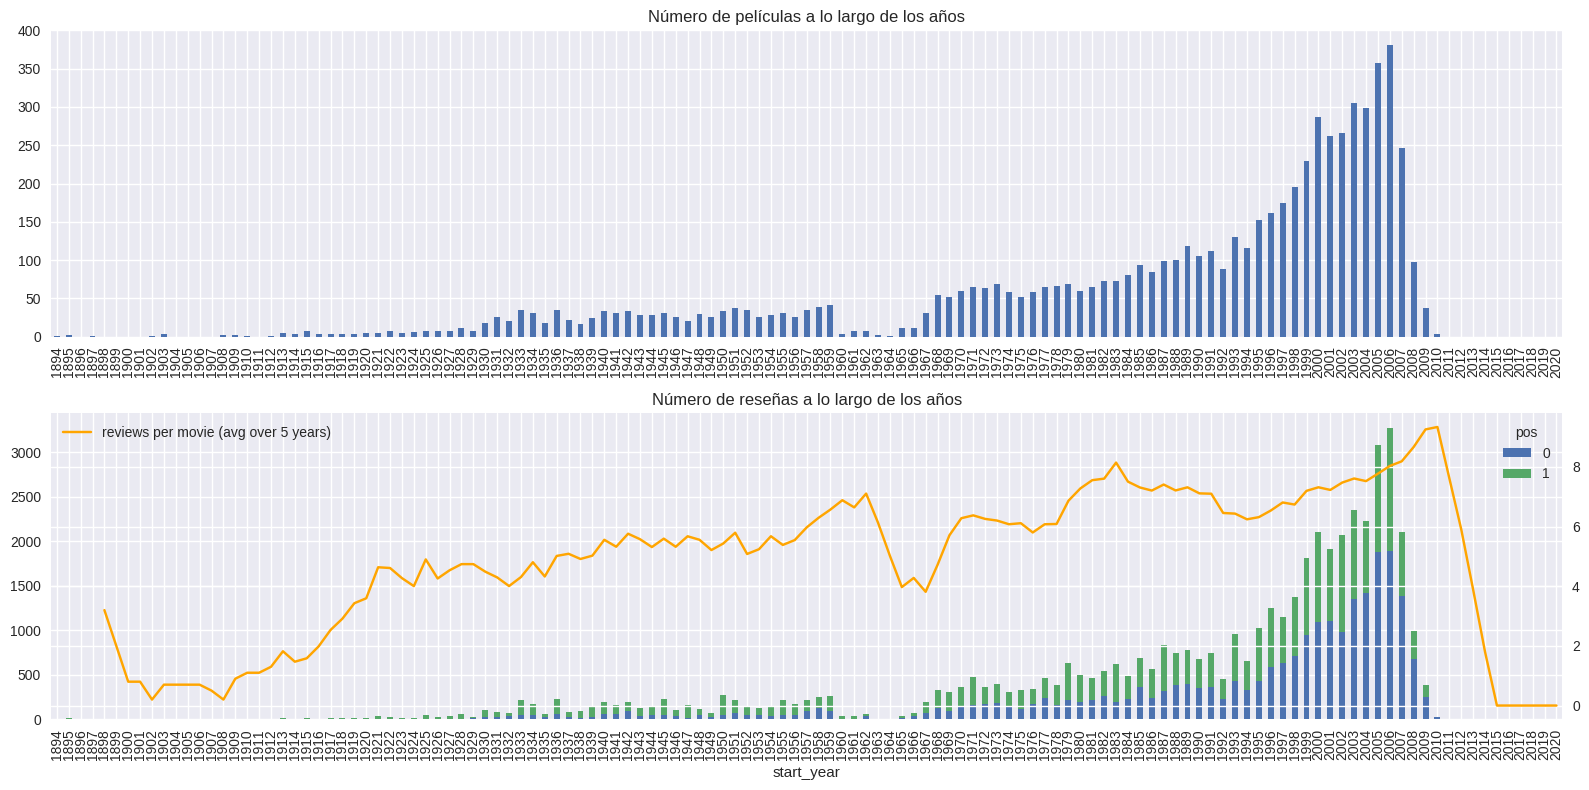

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)


dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

axt.legend()

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

**Resumen de las gráficas**
*   La mayoría de las películas se estrenaron en 2006 (aproximadamente 375 películas)
*   El segundo año con más estrenos fue el 2005 (un poco más de 350 películas)
*   Entre los años 1960 y 1965 hay un descenso considerable en el lanzamiento de películas.
*   Entre los años 1930 y 1959 se estrenaron un número relativamente constante de películas.
*   Luego del bache de 1965 comienza un aumento constante en el estreno de películas, hasta el 2006 que el descenso es drástico. 
*   Las opiniones positivas y negativas son bastantes equilibradas.
---





Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

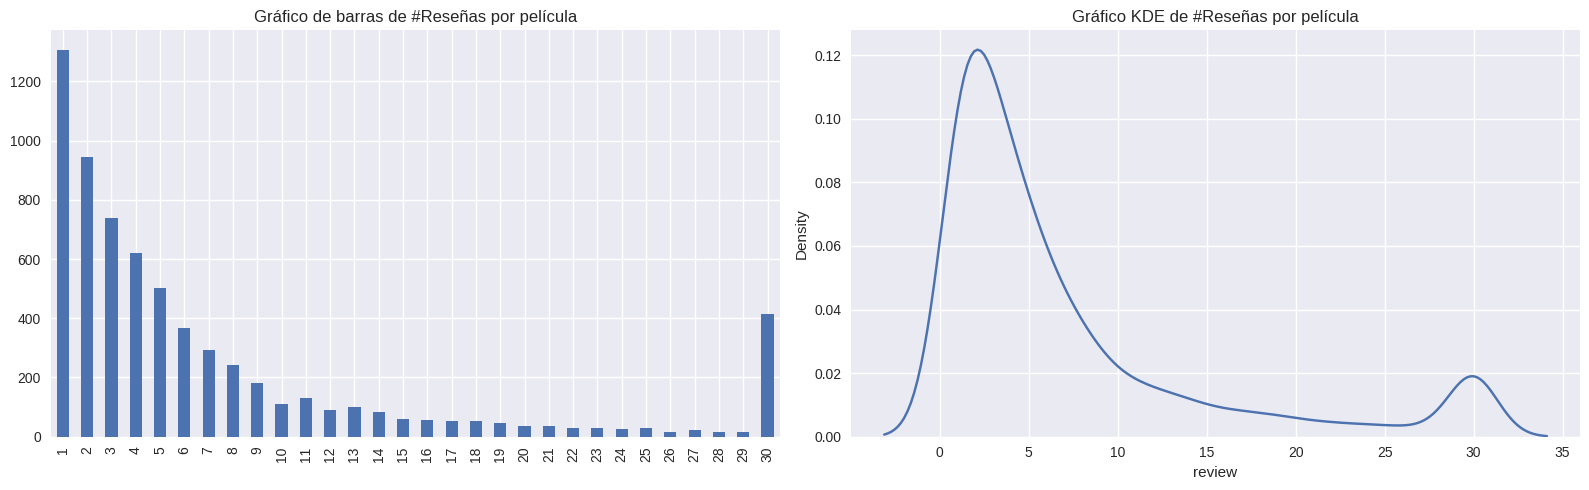

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

**Resumen de las gráficas**
*   La mayoría de las películas tienen una sola reseña (más de 1200 películas)
*   Vemos una variable en cuanto al número de 30 opiniones, ya que incrementa considerablemente, aproximadamente 400 películas)
---

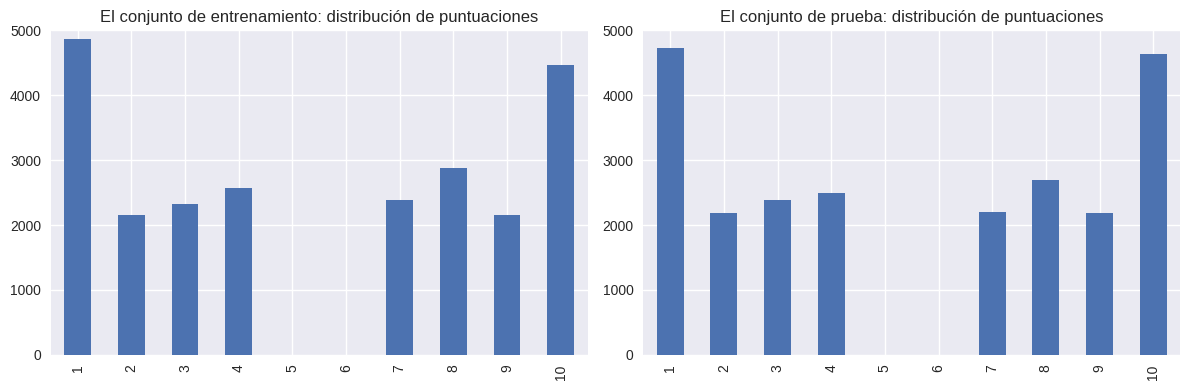

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

**Resumen de las gráficas**
*   La distribución en el entrenamiento y en la prueba son equilibradas
*   La mayor puntuación es 1.
*   No hay puntuaciones entre 5 y 6 puntos.
*   La segunda puntuación más alta es 10.
---

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

In [20]:
print('Total de reseñas positivas (1) y reseñas negativas (0) en el dataset: ')
display(df_reviews['pos'].value_counts().reset_index(drop=True))

print('\nTotal de reseñas positivas (1) y reseñas negativas (0) en el dataset de entrenamiento: ')
display(df_reviews.query('ds_part == "train"')['pos'].value_counts().reset_index(drop=True))

print('\nTotal de reseñas positivas (1) y reseñas negativas (0) en el dataset de testeo: ')
display(df_reviews.query('ds_part == "test"')['pos'].value_counts().reset_index(drop=True))

Total de reseñas positivas (1) y reseñas negativas (0) en el dataset: 


0    23715
1    23616
Name: pos, dtype: int64


Total de reseñas positivas (1) y reseñas negativas (0) en el dataset de entrenamiento: 


0    11912
1    11884
Name: pos, dtype: int64


Total de reseñas positivas (1) y reseñas negativas (0) en el dataset de testeo: 


0    11803
1    11732
Name: pos, dtype: int64

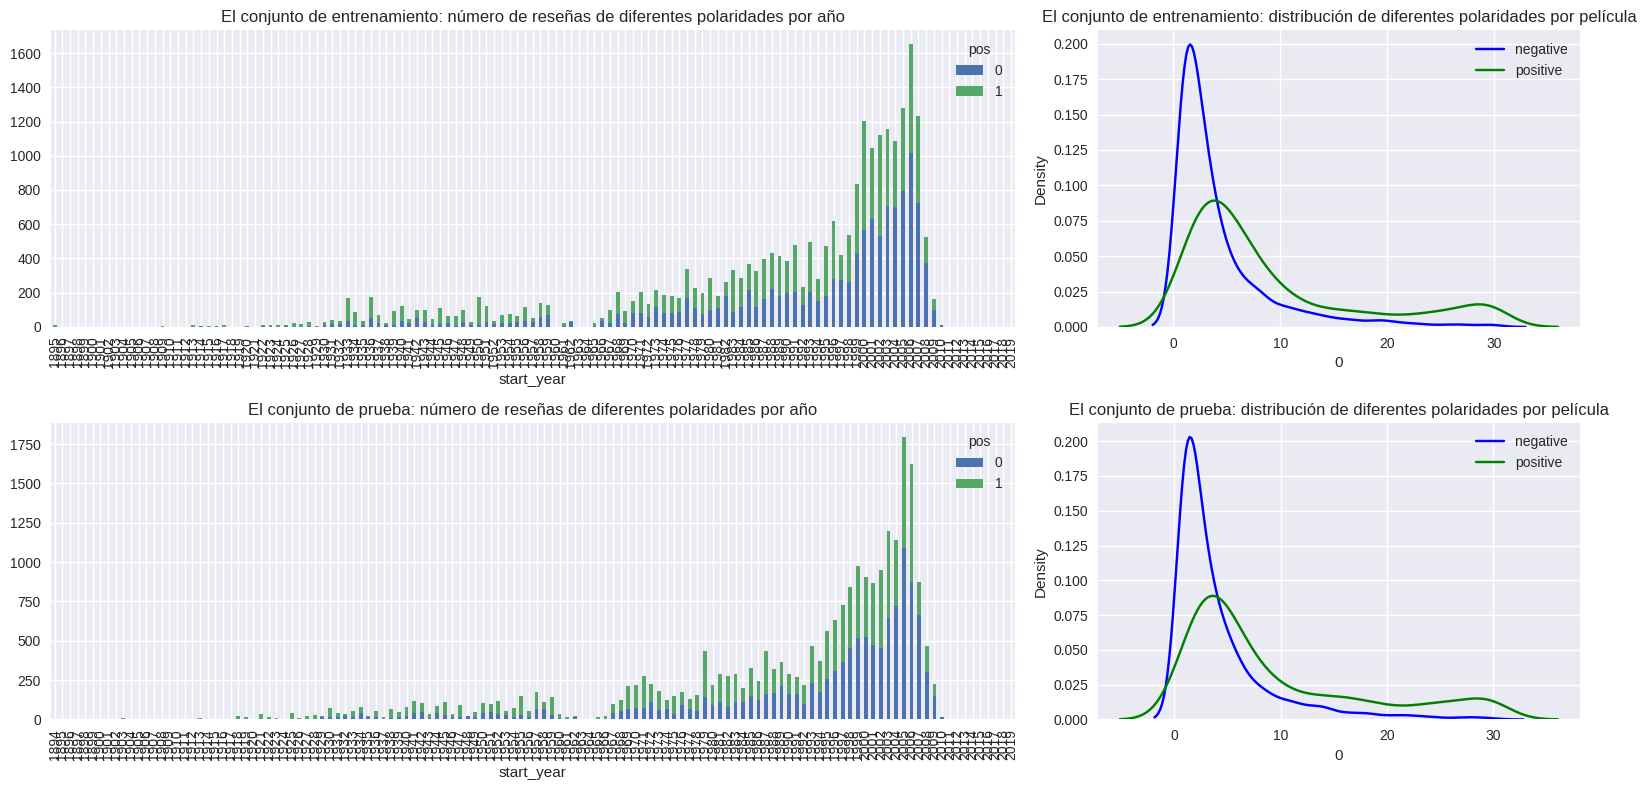

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

**Resumen de las gráficas**
 




*   El total de reseñas **positivas** en el dataset es de **23.616**
*   El total de reseñas **negativas** en el dataset es de **23.715**
*   El total de reseñas **positivas** en el dataset de entrenamiento es de **11.884**
*  El total de reseñas **negativas** en el dataset de entrenamiento es de **11.912**
*   El total de reseñas **positivas** en el dataset de testeo es de **11.732**
*  El total de reseñas **negativas** en el dataset de testeo es de **11.803**
*   La distribución de las polaridades de las revisiones entre el conjunto de entrenamiento y en el de prueba son similares.
---

In [22]:
def create_word_cloud(df, target, val=1, is_filter=True, title=None):
    text = ''
    if is_filter:
        pat = re.compile(r'movie|film|saw|really|watched|first|one|time|s|even')
        text = " ".join(re.sub(pat, '', review) for review in df[df[target] == val]['review'])
    else:
        text = " ".join(review for review in df[df[target] == val]['review'])
    wc = WordCloud(collocations=False, background_color='white').generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

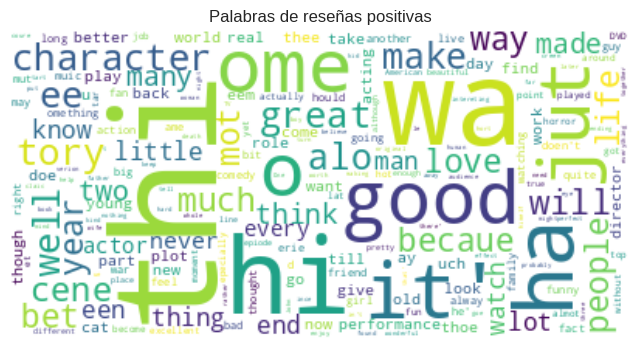

In [23]:
create_word_cloud(df_reviews, 'pos', val=1, is_filter=True, title='Palabras de reseñas positivas')

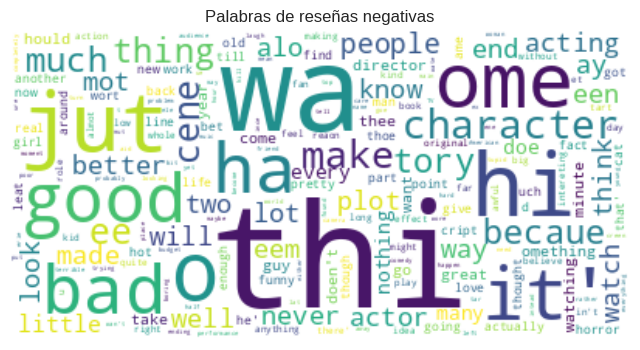

In [24]:
create_word_cloud(df_reviews, 'pos', val=0, is_filter=True, title='Palabras de reseñas negativas')

**Resumen de las gráficas**


*   La nube de palabras aparentemente no diferencia entre buenas y malas críticas.
*   Las palabras más destacadas encontramos:
    1.   thi
    2.   wa
    3.   good
    4.   great
    5. bad
* Vemos que es importante eliminar las "stopwords" para el modelado de los datos.

---



**Primeras conclusiones**



*  La mayoría de las películas se estrenaron en 2006.
*   Las clases parecen equilibradas.
*   La mayoría de las películas tienen una sola reseña.
*   Cerca de 400 películas tienen 30 reseñas cada una.

*   La distribución de calificaciones tanto en el entrenamiento como en testeo es similar.

*   La distribución de las polaridades de las críticas cinematográficas a lo largo de los años es similar.
*   La nube de palabras de críticas positivas y negativas revela que las palabres más destacadas son:
thi, wa, good, great, bad.
*   Es de suma importancia hacer una buena limpieza de datos para poder modelar y obtener los mejores resultados posibles.
---


## procedimiento de evaluación

Desarrollaremos una función de evaluación que se pueda utilizar para evaluar todos los modelos.

Esta función obtendrá predicciones de los modelos, así como las probabilidades predichas, y creará gráficos ROC y PRC, así como también graficará las puntuaciones F1 en varios umbrales. También guardará las estadísticas críticas en un diccionario, que se imprimirá como un marco de datos. Las estadísticas críticas que se mostrarán son las siguientes:

**Accuracy** - Número de predicciones correctas sobre el total de predicciones. Una puntuación de precisión alta es buena cuando hay un número igual de observaciones pertenecientes a cada clase.

**F1** - Medios armónicos entre precisión y recuperación. Utilizamos la puntuación F1 para encontrar el equilibrio óptimo entre precisión y recuperación.

**APS**: puntaje de precisión promedio en todos los umbrales. Es esencialmente el área bajo la puntuación de recuperación de precisión. Cuanto mayor sea la puntuación, mejor.

**ROC AUC:** el área bajo la curva de características operativas del receptor, que traza la tasa de falsos positivos de un modelo frente a su verdadera tasa de positivos. Cuanto mayor sea la puntuación, mejor será el modelo.


Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [25]:
def evaluate_model(model, features_train, target_train, features_test, target_test):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', features_train, target_train), ('test', features_test, target_test)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [26]:
df_reviews['review'].head()

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
3    Um .... a serious film about troubled teens in...
4    I'm totally agree with GarryJohal from Singapo...
Name: review, dtype: object

In [27]:
def clean_text(row):
    text = row['review']
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    text = " ".join(text)    
    return text

In [28]:
df_reviews['review_norm'] = df_reviews.apply(clean_text, axis=1)

In [29]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i am totally agree with garryjohal from singap...
Name: review_norm, dtype: object

In [30]:
#create_word_cloud(df_reviews, 'pos', val=0, is_filter=True, title='Palabras de reseñas negativas')

## división entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [31]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

features_train =   df_reviews_train.drop('pos', axis=1)
features_test =  df_reviews_test.drop('pos', axis=1)

target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']



print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## trabajar con modelos

En esta sección, construiremos y evaluaremos varios modelos de clasificación con el objetivo de construir uno que prediga si una reseña es positiva o negativa con una puntuación F1 superior a 0.85. Para evaluar los modelos, utilizaremos la función **evaluate_model** que desarrollamos en la sección anterior.

### modelo 0 - constante

In [32]:
model_0 = DummyClassifier(strategy='stratified', random_state=12345).fit(features_train,target_train)

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


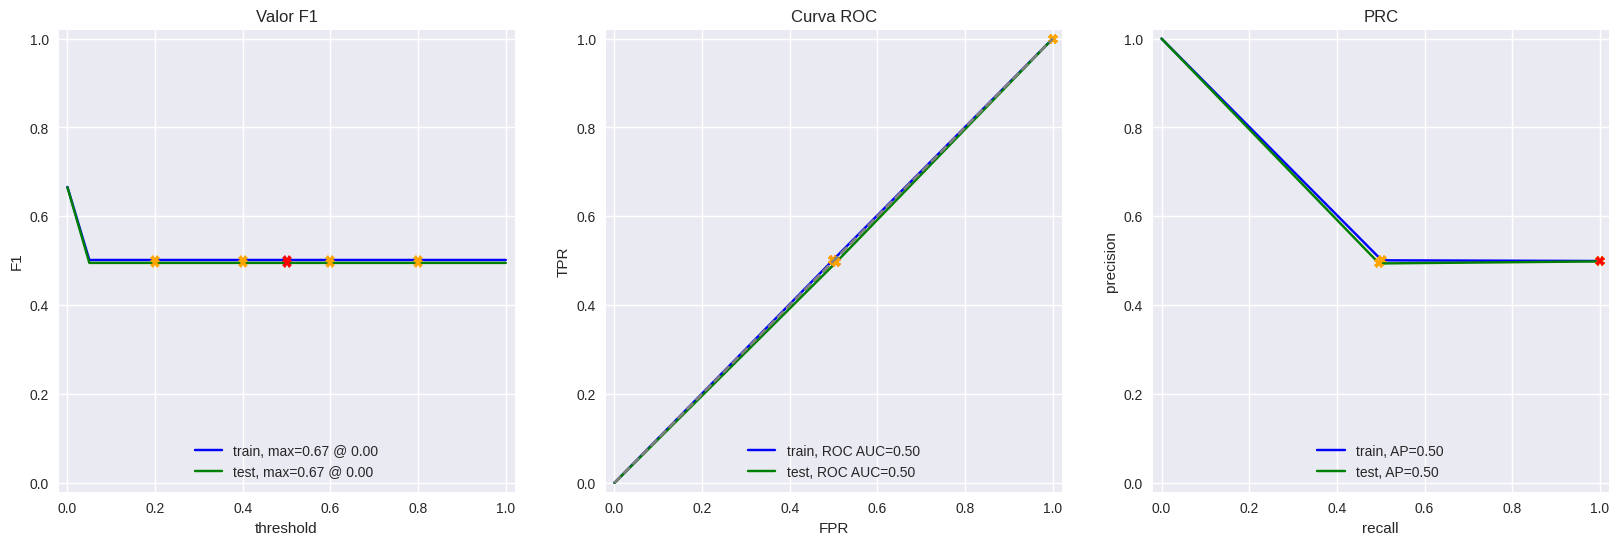

In [33]:
evaluate_model(model_0, features_train, target_train, features_test, target_test)

**Resultados del modelo:** DummyClassifier

**1.   En entrenamiento:**

*   Accuracy   0.50 
*   F1         0.50
*   APS        0.50 
*   ROC AUC    0.50 



**2.   En testeo:**

*   Accuracy   0.50 
*   F1         0.50
*   APS        0.50 
*   ROC AUC    0.50


 El modelo DummyClassifier, es útil solamente para tener una base y comparar con otros modelos. En las gráficas vemos claramente cómo las posibilidades de que ocurra cualquiera de los dos eventos (reseña positiva o negativa) es la misma. No es un modelo confiable.  

 ---

### modelo 1 - NLTK, TF-IDF Logistic Regression

El siguiente modelo será un modelo de regresión logística. Vectorizaremos las reseñas con el método tf-idf, para eliminar las palabras vacías comunes de cada reseña. Antes de la vectorización, utilizaremos WordNetLemmatizer de NLTK para lematizar las reseñas en los conjuntos de prueba y entrenamiento.

In [34]:
lemmatizer  = WordNetLemmatizer()

In [35]:
stop_words = stopwords.words('english')
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [36]:
def text_lemma(row):
    text = row['review_norm']
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

df_reviews_train['review_lemma'] = df_reviews_train.apply(text_lemma, axis=1)
df_reviews_test['review_lemma'] = df_reviews_test.apply(text_lemma, axis=1)

In [37]:
stop_words = nltk_stopwords.words('english')
count_tf_idf_nltk = TfidfVectorizer(stop_words=stop_words)
corpus_train = df_reviews_train['review_lemma']
corpus_test = df_reviews_test['review_lemma']

# creating a TF-IDF matrix without stop words
features_train_1 = count_tf_idf_nltk.fit_transform(corpus_train)
features_test_1 = count_tf_idf_nltk.transform(corpus_test)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


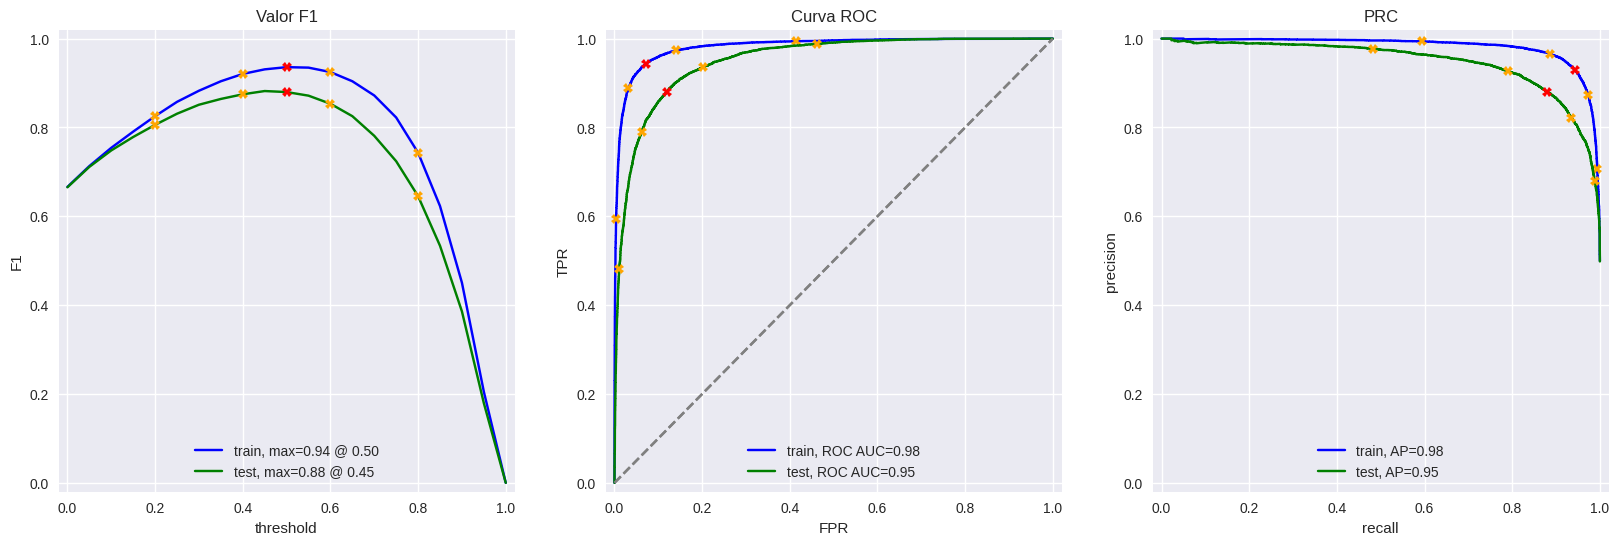

In [38]:
model_1 = LogisticRegression()
model_1.fit(features_train_1, target_train)
evaluate_model(model_1, features_train_1, target_train, features_test_1, target_test)

**Resultados del modelo:**

LogisticRegression

**1.   En entrenamiento:**

*   Accuracy   0.94 
*   F1         0.94
*   APS        0.98 
*   ROC AUC    0.98 


**2.   En testeo:**

*   Accuracy   0.88 
*   F1         0.88
*   APS        0.95 
*   ROC AUC    0.95




 El modelo de regresión logistica obtuvo en entrenamiento una puntuación de precisión promedio APS casi perfecta, así como una puntuación AUC ROC. En lo que respecta a la F1, la puntuación del conjunto de entrenamiento fue más alta que la del conjunto de prueba. De cualquier manera, este modelo obtuvo una puntuación en testeo de 0.88, es decir, más alta que la puntuación mínima especificada por la empresa (es decir, 0.85).
 
Podríamos pensar por las gráficas que estamos frente a un síntoma de overfitting ya que las métricas en testeo sólo son buenas hasta que el threshold está en 0.2. Continuemos con los demás modelos para comparar.

 ---

### modelo 2 spaCy, TF-IDF - Logistic Regression

El siguiente modelo será similar al modelo de Regresión Logística, excepto que usaremos spaCy para lematizar las palabras de cada revisión. Luego, vectorizaremos las palabras según su TF-IDF y crearemos, entrenaremos y probaremos un modelo de regresión logística.

In [39]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [40]:
def text_preprocessing_2(row):
    text = row['review_norm']
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
#     tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [41]:
df_reviews_train['review_lemma_2'] = df_reviews_train.apply(text_preprocessing_2, axis=1)
df_reviews_test['review_lemma_2'] = df_reviews_test.apply(text_preprocessing_2, axis=1)

In [42]:
count_tf_idf_spacy = TfidfVectorizer()
corpus_train = df_reviews_train['review_lemma_2']
corpus_test = df_reviews_test['review_lemma_2']

# creating a TF-IDF matrix without stop words
features_train_2 = count_tf_idf_spacy.fit_transform(corpus_train)
features_test_2 = count_tf_idf_spacy.transform(corpus_test)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


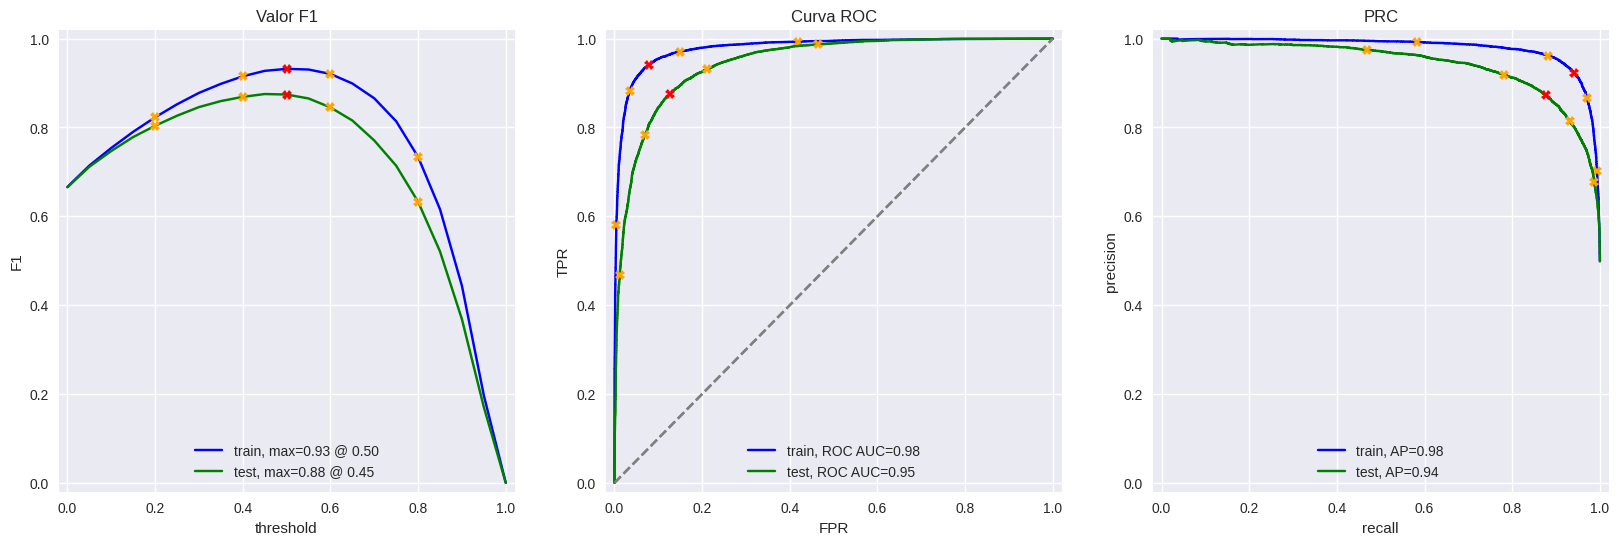

In [43]:
model_2 = LogisticRegression()
model_2.fit(features_train_2, target_train)
evaluate_model(model_2, features_train_2, target_train, features_test_2, target_test)

**Resultados del modelo:** spaCy, TF-IDF-Logistic Regression

**1.   En entrenamiento:**

*   Accuracy   0.93
*   F1         0.93
*   APS        0.98 
*   ROC AUC    0.98 



**2.   En testeo:**

*   Accuracy   0.87 
*   F1         0.87
*   APS        0.94 
*   ROC AUC    0.95



 
 El modelo spaCy, TF-IDF-Logistic Regression, obtuvimos resultados más bajos que en la regresión logisitica, incluso hasta en el testeo no es tan eficiente y también es más lento el proceso de tokenización y entrenamiento, pero de cualquier manera este modelo cumple con los criterios de puntaje mínimo especificados por Film Junky Union.
 
Al igual que el modelo de regresión logística, este modelo presenta overfitting y el punto en donde se minimiza es cuando el threshold está en 0.2.

El siguiente modelo usaremos los mismos datos de spaCy y probaremos un modelo de clasificador LGBM.

 ---


### modelo 3 - LGBMClassifier

In [44]:
features_train_3 = count_tf_idf_spacy.fit_transform(corpus_train)
features_test_3 = count_tf_idf_spacy.transform(corpus_test)

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


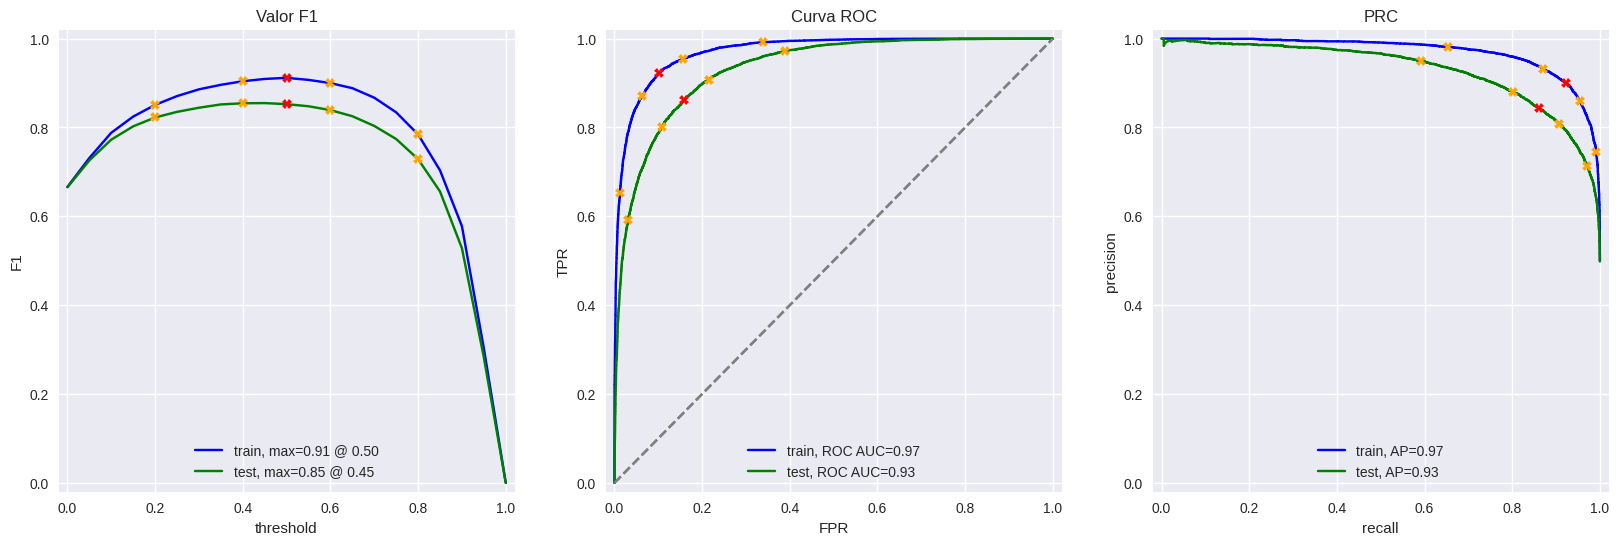

In [45]:
model_3 = LGBMClassifier()
model_3.fit(features_train_3,target_train)
target_pred = model_3.predict(features_train_3)
evaluate_model(model_3,features_train_3, target_train, features_test_3, target_test)

**Resultados del modelo:** LGBMClassifier

**1.   En entrenamiento:**

*   Accuracy   0.91
*   F1         0.91
*   APS        0.97 
*   ROC AUC    0.97 



**2.   En testeo:**

*   Accuracy   0.85 
*   F1         0.85
*   APS        0.93 
*   ROC AUC    0.93


El modelo LGBMClassifier, no obtuvo tan buenos resultados como en la regresión logisitica, incluso hasta en el testeo no es tan eficiente.

En este modelo podemos apreciar en la gráfica como el overtiffing es incluso mayor antes de que threshold esté en 0.2. Este modelo es el menos confiable hasta ahora.


Continuaremos con el útimo modelo, que entrenaremos y probaremos un modelo BERT para clasificar con precisión las reseñas.

 ---

###  modelo 4 - BERT

BERT (Bidirectional Encoder Representations from Transformers) es una técnica de aprendizaje automático basada en transformadores desarrollada por Google para el procesamiento del lenguaje natural. A continuación construiremos, entrenaremos y probaremos un modelo BERT con regresión logística y examinaremos las métricas.

In [46]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')
    
    # <put your code here to create ids_list and attention_mask_list>
    ids_list = texts.apply(lambda x: tokenizer.encode(x.lower(), add_special_tokens=True, truncation=True, max_length=max_length))
    
    ids_list = ids_list.apply(lambda x: np.array(x[:max_length] + [0]*(max_length - len(x))))
    attention_mask_list = ids_list.apply(lambda x: np.where(x != 0, 1, 0))
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)

        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)

        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [49]:
# In order to retrain, set to 1, retrain =0 loads precomputed embeddings
retrain = 1
if retrain:
    # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
    features_bert = BERT_text_to_embeddings(df_reviews_train['review_norm'], batch_size=5, force_device='cuda')
    test_bert = BERT_text_to_embeddings(df_reviews_test['review_norm'], batch_size=5, force_device='cuda')
    # save the embeddings
    np.savez_compressed('bert.npz', features_bert=features_bert, test_bert=test_bert)
    print('embeddings generated and saved successfully')
else:
    with np.load('bert.npz') as data:
        features_bert = data['features_bert']
        test_bert = data['test_bert']
        print('Features loaded successfully')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using the cuda device.


  0%|          | 0/4760 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using the cuda device.


  0%|          | 0/4707 [00:00<?, ?it/s]

embeddings generated and saved successfully


In [50]:
model_4 = LogisticRegression(solver='lbfgs')
model_4.fit(features_bert, target_train)

LogisticRegression()

          train  test
Accuracy   0.88  0.86
F1         0.87  0.86
APS        0.95  0.94
ROC AUC    0.94  0.94


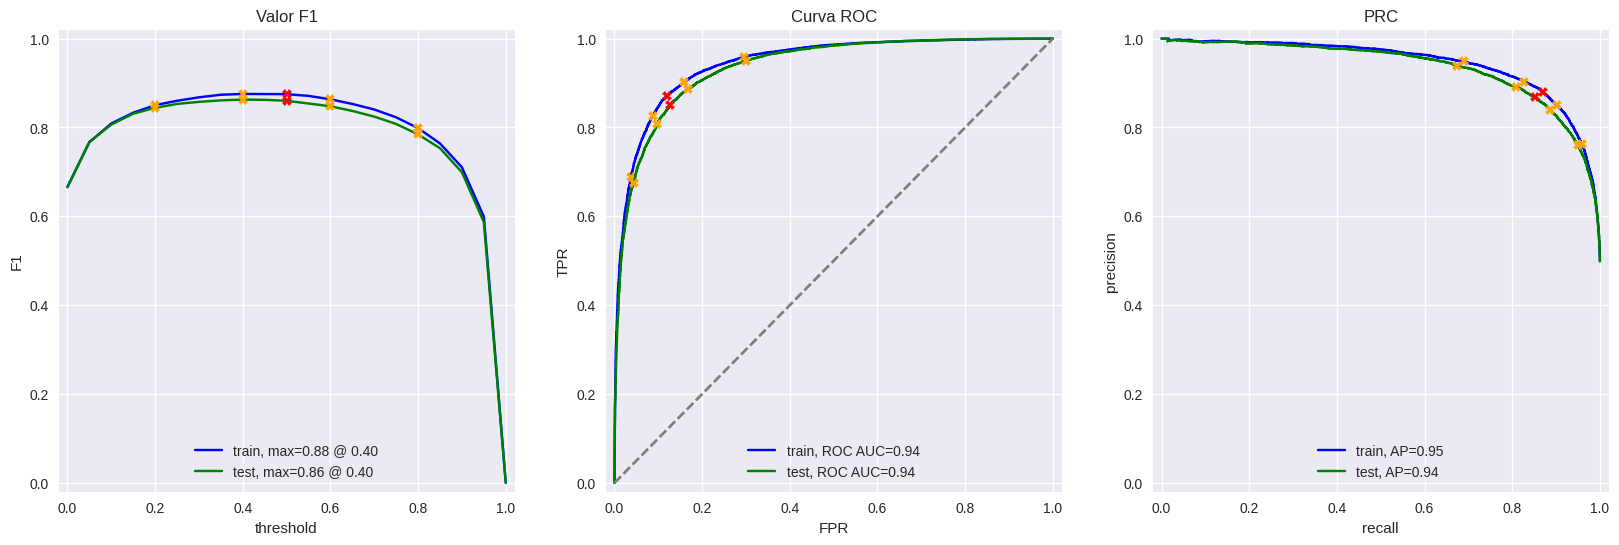

In [51]:
evaluate_model(model_4, features_bert, target_train, test_bert, target_test)

**Resultados del modelo:** BERT

**1.   En entrenamiento:**

*   Accuracy   0.88
*   F1         0.88
*   APS        0.95 
*   ROC AUC    0.95 

**2.   En testeo:**

*   Accuracy   0.86 
*   F1         0.86
*   APS        0.94 
*   ROC AUC    0.94


 El modelo BERT, entrenado con regresión logística, cumple con los estándares de Film Junky Union para un en testeo, es un modelo bastante lento, que necesita muchos recursos para ejecutarse.

---

###  resumen de resultados

Construiremos una tabla para analizar los resultados facilmente.

In [52]:
results = pd.DataFrame({
    'modelo': ['DummyClassifier_train', 'DummyClassifier_test',
               'NLTK_TF_IDF_LogisticRegression_train', 'NLTK_TF_IDF_LogisticRegression_test', 
               'spaCy_LogisticRegression_train', 'spaCy_LogisticRegression_test',
               'TF_IDF__LGBM_train', 'TF_IDF__LGBM_test','BERT_train', 'BERT_test' ],
    'Accuracy':[0.5, 0.5, 0.94, 0.88, 0.93, 0.87, 0.91, 0.85, 0.88, 0.86],
    'F1':[0.5, 0.5, 0.94, 0.88, 0.93, 0.87, 0.91, 0.85, 0.88, 0.86],
    'APS':[0.5, 0.5, 0.98, 0.95, 0.98, 0.95, 0.97, 0.93, 0.95, 0.94],
    'ROC_AUC':[0.5, 0.5, 0.98, 0.95, 0.98, 0.95,0.97, 0.93, 0.95, 0.94]

})
results

,modelo,Accuracy,F1,APS,ROC_AUC
0,DummyClassifier_train,0.50,0.50,0.50,0.50
1,DummyClassifier_test,0.50,0.50,0.50,0.50
2,NLTK_TF_IDF_LogisticRegression_train,0.94,0.94,0.98,0.98
3,NLTK_TF_IDF_LogisticRegression_test,0.88,0.88,0.95,0.95
4,spaCy_LogisticRegression_train,0.93,0.93,0.98,0.98
5,spaCy_LogisticRegression_test,0.87,0.87,0.95,0.95
6,TF_IDF__LGBM_train,0.91,0.91,0.97,0.97
7,TF_IDF__LGBM_test,0.85,0.85,0.93,0.93
8,BERT_train,0.88,0.88,0.95,0.95
9,BERT_test,0.86,0.86,0.94,0.94


In [53]:
results.sort_values(by=['F1'], ascending= False)

,modelo,Accuracy,F1,APS,ROC_AUC
2,NLTK_TF_IDF_LogisticRegression_train,0.94,0.94,0.98,0.98
4,spaCy_LogisticRegression_train,0.93,0.93,0.98,0.98
6,TF_IDF__LGBM_train,0.91,0.91,0.97,0.97
3,NLTK_TF_IDF_LogisticRegression_test,0.88,0.88,0.95,0.95
8,BERT_train,0.88,0.88,0.95,0.95
5,spaCy_LogisticRegression_test,0.87,0.87,0.95,0.95
9,BERT_test,0.86,0.86,0.94,0.94
7,TF_IDF__LGBM_test,0.85,0.85,0.93,0.93
0,DummyClassifier_train,0.50,0.50,0.50,0.50
1,DummyClassifier_test,0.50,0.50,0.50,0.50


Los tres mejores valores de F1:

*   NLTK_TF_IDF_LogisticRegression	
*   spaCy_LogisticRegression
*   TF_IDF__LGBM


## mis reseñas

En esta sección, probaremos nuestros modelos utilizando otras reseñas. Construiremos las reseñas de tal manera que haya un equilibrio de clase equitativo entre las revisiones positivas y negativas. Después de convertir adecuadamente nuestros textos al formato relevante para cada modelo, obtendremos predicciones de cada modelo sobre el sentimiento de nuestras reseñas. A continuación, mostraremos la opinión real y la opinión prevista para cada reseña de cada modelo.

### modelo 0

In [54]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews.apply(clean_text, axis=1)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i did not expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


Cada reseña ha sido procesada de tal forma que solo contiene letras minúsculas.

### modelo 1

In [55]:
my_reviews['review_lemma'] = my_reviews.apply(text_lemma, axis=1)

stop_words = nltk_stopwords.words('english')
count_tf_idf_nltk = TfidfVectorizer(stop_words=stop_words)
my_reviews_corpus_train = df_reviews_train['review_lemma']
my_reviews_corpus_test = my_reviews['review_lemma']

# creating a TF-IDF matrix without stop words
my_reviews_train_features_1 = count_tf_idf_nltk.fit_transform(my_reviews_corpus_train)
my_reviews_test_features_1 = count_tf_idf_nltk.transform(my_reviews_corpus_test)

In [56]:
texts = my_reviews['review_lemma']

my_reviews_pred_prob = model_1.predict_proba(my_reviews_test_features_1)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

0.85:  I did not simply like it, not my kind of movie.
0.86:  Well, I was bored and felt asleep in the middle of the movie.
0.54:  I was really fascinated with the movie
0.88:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.70:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.47:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.97:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.13:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


Conclusiones del Modelo 1:

- Las predicciones en las 8 reseñas anteriores no es muy confiable.
- A simple vista al modelo le costó entender cuando palabras ambigüas como "well" o "really" y no supo entender con el contexto si se trataba de una crítica positiva o negativa.
- Se sugiere estudiar los tokens para que el modelo pueda aprender mejor y en testeo tenga un mejor desempeño.  

### modelo 2

In [57]:
my_reviews['review_lemma_2'] = my_reviews.apply(text_preprocessing_2, axis=1)
count_tf_idf_spacy = TfidfVectorizer()
my_reviews_corpus_train = df_reviews_train['review_lemma_2']
my_reviews_corpus_test = my_reviews['review_lemma_2']

# creating a TF-IDF matrix without stop words
my_reviews_train_features_2 = count_tf_idf_spacy.fit_transform(my_reviews_corpus_train)
my_reviews_features_2 = count_tf_idf_spacy.transform(my_reviews_corpus_test)

In [58]:
texts = my_reviews['review_lemma_2']

my_reviews_pred_prob = model_2.predict_proba(my_reviews_features_2)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

0.85:  I did not simply like it, not my kind of movie.
0.92:  Well, I was bored and felt asleep in the middle of the movie.
0.50:  I was really fascinated with the movie
0.85:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.76:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.61:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.97:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.10:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


Conclusiones del Modelo 2:

- Las predicciones en las 8 reseñas anteriores sigue siendo poco  confiable, como en el modelo anterior.
- A simple vista al modelo le costó entender cuando palabras ambigüas como "well" o "really" y no supo entender con el contexto si se trataba de una crítica positiva o negativa.
- Se sugiere estudiar los tokens para que el modelo pueda aprender mejor y en testeo tenga un mejor desempeño.  

### modelo 3

In [59]:
texts = my_reviews['review_lemma_2']

my_reviews_pred_prob = model_3.predict_proba(my_reviews_features_2)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

0.45:  I did not simply like it, not my kind of movie.
0.74:  Well, I was bored and felt asleep in the middle of the movie.
0.43:  I was really fascinated with the movie
0.60:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.34:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.50:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.71:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.27:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


Conclusiones del Modelo 3:

- Igual que los dos modelos anteriores, al modelo le cuesta entender las negaciones y las palabras ambiguas. 
- Habría que revisar los tokens.  

### modelo 4

In [60]:
texts = my_reviews['review_norm']

my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_4)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.27:  I did not simply like it, not my kind of movie.
0.01:  Well, I was bored and felt asleep in the middle of the movie.
0.98:  I was really fascinated with the movie
0.00:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.17:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.97:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.08:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.93:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


Conclusiones del Modelo 4:

- A diferencia de las predicciones anteriores, este modelo está más apegado a la realidad.
- El modelo supo distinguir entre palabras ambigüas, asumimos que por el contexto.
- Es el modelo que más aciertos obtuvo en las predicciones.  

## conclusiones

Luego de hacer un estudio exhaustivo para Film Junky Union, con el objetivo de desarrollar un sistema para filtrar y categorizar reseñas de películas, estudiamos 47.331 datos y entrenamos 4 modelos diferentes para detectar críticas negativas de forma automática, teniendo como base que el modelo debe alcanzar un valor F1 de al menos 0.85.

En este estudio podemos concluir de los datos suministrados lo siguiente:

*   Las reseñas están comprendidas entre los años 1894 y 2010.
*   La columna `pos` indica que aproximadamente la mitad de las reseñas son positivas y las otras negativas.
*   La puntuación: `rating`oscila entre 1.4 y 9.7.
*   El número de votos va de 9 a un mil 739 millones de votos.
*   La mayoría de las películas se estrenaron en 2006 (aproximadamente 375 películas)
*   El segundo año con más estrenos fue el 2005 (un poco más de 350 películas)
*   Las opiniones positivas y negativas son bastantes equilibradas.

*   NLTK TF-IDF y spaCy ambos en Regresión Logística obtienen los valores más altos de F1, a la vez son los modelos más rápidos y eficientes, pero suponemos existe un overfitting ya que en el testeo la métrica no es tan alta.
*  El modelo LGBM Classifier es mucho más lento y no tiene una diferencia significante en la métrica.
*   BERT no tiene el mejor resultado de F1 y resulta ser muy lento, pero es la que menos overfitting presenta. No se recomienda si no se tienen los recursos disponibles (excelente hardward y tiempo, entre otros).
* A la hora de las predicciones el modelo que mejor tuvo resultados fue el BERT, ya que obtuvo la mayor cantidad de aciertos en las predicciones, pero es un modelo lento y costoso.
* Como recomendacion adional, podríamos sugerir hacer un trabajo adicional con los tokens para ayudar al modelo con el aprendizaje y mejorar la métrica en testeo y poder aplicar cualquiera de las dos técnicas (NLTK TF-IDF y spaCy), ya que la velocidad es mucho mayor a la del BERT.